# **Misclassification spotter Part 1 : Spotter**


Example application of spectrogram approach to identify misclassified audios in a dataset

## Libraries

In [1]:
import os
import pandas as pd
import librosa.display
import numpy as np
from pandas.core.common import flatten
import datetime
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy
import pickle
from pathlib import Path

In [2]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
UMAP_COORDS = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "interim", "parameter_search")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")
EXTERNAL_DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "external")

## Load dataset

In [3]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl"))

labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

embedding_filename = 'basic_UMAP_3D_'+dftype+'_default_params.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

# Spotter

## Find nearest neighbors

In [4]:
k=5

nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [5]:
label_col = 'call_lable'
labels = spec_df[label_col].tolist()

In [6]:
wrong_neighbors = []
wrong_neighbors_row_num = []
wrong_datapoint = []
wrong_rownum = []

for i in range(spec_df.shape[0]):
    datapoint_label = labels[i]
    neighbors = indices[i]
    neighbor_labels = [labels[x] for x in neighbors]
    
    if datapoint_label not in neighbor_labels:
        wrong_neighbors.append(neighbor_labels)
        wrong_neighbors_row_num.append(neighbors)
        wrong_datapoint.append(datapoint_label)
        wrong_rownum.append(i)

In [7]:
len(wrong_neighbors)

539

In [8]:
wrong_df = pd.DataFrame(list(zip(wrong_rownum, wrong_datapoint)), 
               columns =['row_num', 'call_lable']) 

wrong_neighbors_arr = np.vstack(wrong_neighbors)

for i in range(wrong_neighbors_arr.shape[1]):
    col_name = "neighbor_"+str(i+1)
    wrong_df[col_name] = wrong_neighbors_arr[:,i]

wrong_neighbors_row_num_arr = np.vstack(wrong_neighbors_row_num)

for i in range(wrong_neighbors_row_num_arr.shape[1]):
    col_name = "neighbor_"+str(i+1)+"_rownum"
    wrong_df[col_name] = wrong_neighbors_row_num_arr[:,i]

wrong_df

row_num call_lable neighbor_1 neighbor_2 neighbor_3 neighbor_4  \
0          7        agg        soc        soc        soc        soc   
1          8        agg         al        soc         cc        soc   
2         12        agg         cc         cc        soc         cc   
3         14        agg         sn         cc         sn         sn   
4         15         al         sn        agg         sn         sn   
..       ...        ...        ...        ...        ...        ...   
534     6390         cc        soc         al        soc        soc   
535     6392         cc        agg        agg         sn        soc   
536     6393         cc        soc        soc         al         al   
537     6415         cc         al        soc        soc        soc   
538     6421         cc         ld         ld         ld         ld   

    neighbor_5  neighbor_1_rownum  neighbor_2_rownum  neighbor_3_rownum  \
0          soc                363                636               3790   
1          soc                106                993               5990   
2           cc               5850               6394               2365   
3           sn                175               5140               3449   
4          agg                483               2313               1017   
..         ...                ...                ...                ...   
534        soc               1960                109               2167   
535        agg               1901               1888                333   
536        soc               2151               2155                858   
537        agg                 58               2162               1919   
538         ld               1051               1464               1034   

     neighbor_4_rownum  neighbor_5_rownum  
0                  371                247  
1                 1645               1701  
2                 5389               6201  
3                  999                895  
4                  442               4513  
..                 ...                ...  
534               2557               1887  
535               1963               2320  
536                859                613  
537               1700               2323  
538               1479               1497  

[539 rows x 12 columns]

### Descriptive statistics

In [9]:
wrong_df['call_lable'].value_counts()

soc    104
al      99
cc      83
mo      68
agg     66
sn      61
ld      58
Name: call_lable, dtype: int64

In [10]:
w = pd.DataFrame(wrong_df['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df[label_col].value_counts())
a.sort_index(inplace=True)

In [11]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a[label_col], 'percentage': 100*(w['call_lable']/a[label_col])})
tab

mispositioned  overall  percentage
agg             66      375   17.600000
al              99      646   15.325077
cc              83     1477    5.619499
ld              58      164   35.365854
mo              68      759    8.959157
sn              61     1855    3.288410
soc            104     1154    9.012132

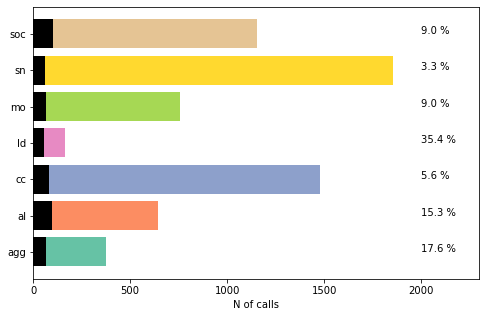

In [12]:
fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df[label_col].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts[label_col].values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.xlim(0,2300)
for index, value in enumerate(tab.mispositioned.values):
    plt.text(2000, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

### Clear cases

Identify "clear" cases, where all neighbors are of the same label type.

In [13]:
nb_cols=[]
for i in range(k):
    nb_cols.append('neighbor_'+str(i+1))
nb_cols

['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']

In [14]:
clear_cases = []

for i in range(wrong_df.shape[0]):
    nbs = wrong_df.loc[i,nb_cols].tolist()
    if len(set(nbs))==1:
        clear_cases.append('yes')
    else:
        clear_cases.append('no')

In [15]:
wrong_df['clear_case'] = clear_cases
wrong_df.clear_case.value_counts()

no     333
yes    206
Name: clear_case, dtype: int64

Okay, for some calls, there seems to be a clear mislabeling. Plot some example calls:

In [16]:
wrong_df.head()

row_num call_lable neighbor_1 neighbor_2 neighbor_3 neighbor_4 neighbor_5  \
0        7        agg        soc        soc        soc        soc        soc   
1        8        agg         al        soc         cc        soc        soc   
2       12        agg         cc         cc        soc         cc         cc   
3       14        agg         sn         cc         sn         sn         sn   
4       15         al         sn        agg         sn         sn        agg   

   neighbor_1_rownum  neighbor_2_rownum  neighbor_3_rownum  neighbor_4_rownum  \
0                363                636               3790                371   
1                106                993               5990               1645   
2               5850               6394               2365               5389   
3                175               5140               3449                999   
4                483               2313               1017                442   

   neighbor_5_rownum clear_case  
0                247        yes  
1               1701         no  
2               6201         no  
3                895         no  
4               4513         no

Remove unknown calls and only select clear cases

In [17]:
wrong_subset = wrong_df.loc[wrong_df['clear_case']=='yes']
wrong_subset = wrong_subset.loc[wrong_subset['call_lable']!='unk']

# Need to reset index, else won't be able to accces ith row of original dataframe
spec_df.reset_index(inplace=True)

calltypes = sorted(list(set(wrong_subset['call_lable'])))
calltypes

['agg', 'al', 'cc', 'ld', 'mo', 'sn', 'soc']

In [18]:
wrong_subset.head()

row_num call_lable neighbor_1 neighbor_2 neighbor_3 neighbor_4 neighbor_5  \
0         7        agg        soc        soc        soc        soc        soc   
5        16         al         sn         sn         sn         sn         sn   
6        17         al         cc         cc         cc         cc         cc   
8        21         al         cc         cc         cc         cc         cc   
22       61         al         cc         cc         cc         cc         cc   

    neighbor_1_rownum  neighbor_2_rownum  neighbor_3_rownum  \
0                 363                636               3790   
5                1004                193               1339   
6                5869               5472               5284   
8                4961               6412               5220   
22               5758               5662               6267   

    neighbor_4_rownum  neighbor_5_rownum clear_case  
0                 371                247        yes  
5                 176               4876        yes  
6                4983               5868        yes  
8                6047               5633        yes  
22               5791               6290        yes

In [19]:
w = pd.DataFrame(wrong_subset['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df[label_col].value_counts())
a.sort_index(inplace=True)

In [20]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a[label_col], 'percentage': 100*(w['call_lable']/a[label_col])})
tab

mispositioned  overall  percentage
agg             26      375    6.933333
al              49      646    7.585139
cc              16     1477    1.083277
ld              23      164   14.024390
mo              28      759    3.689065
sn              17     1855    0.916442
soc             47     1154    4.072790

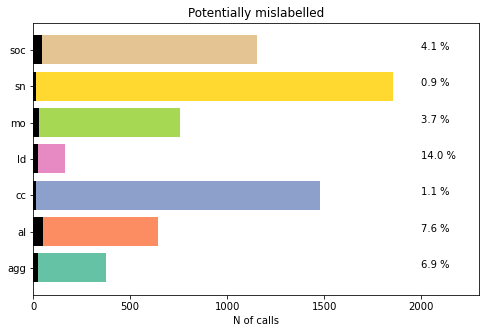

In [21]:
fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df[label_col].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts[label_col].values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.title("Potentially mislabelled")
plt.xlim(0,2300)
for index, value in enumerate(tab.mispositioned.values):
    plt.text(2000, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

### Plot example misclassified calls

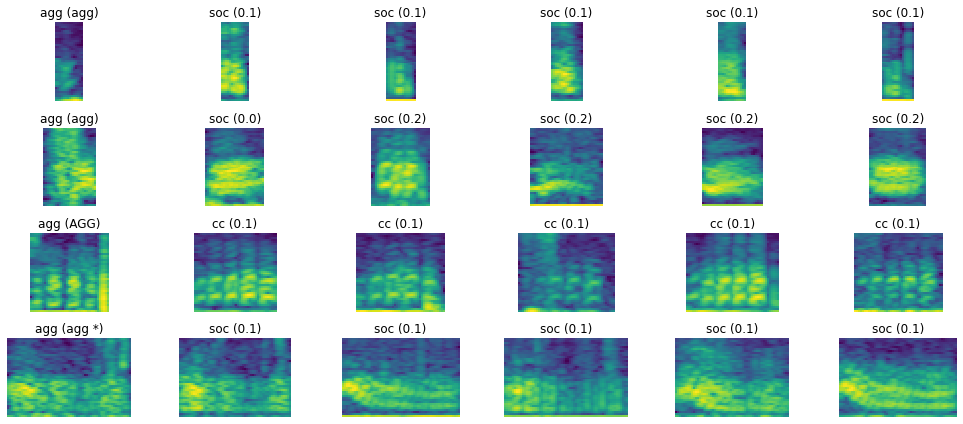

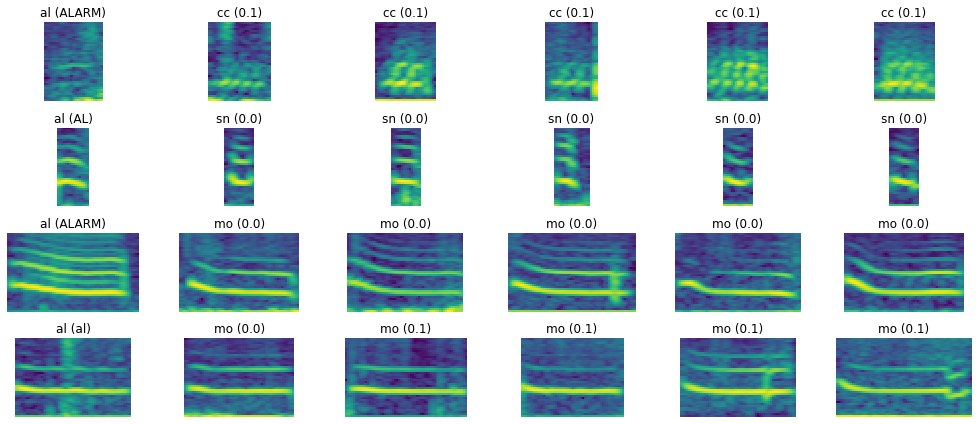

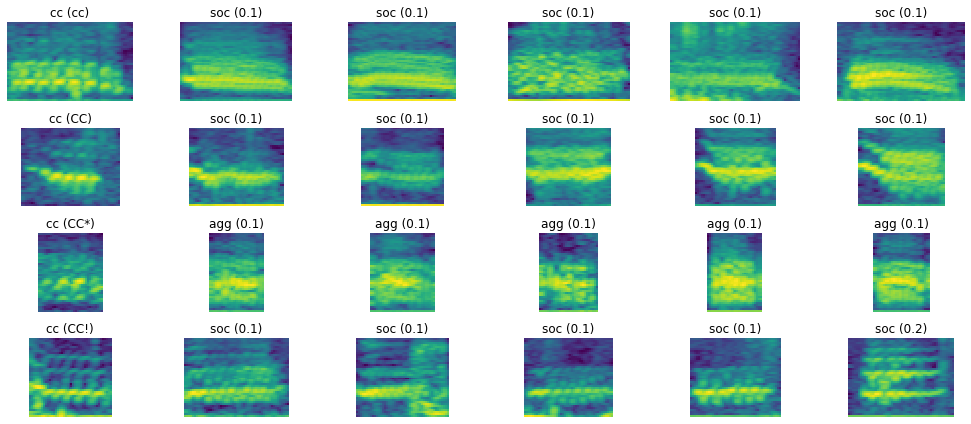

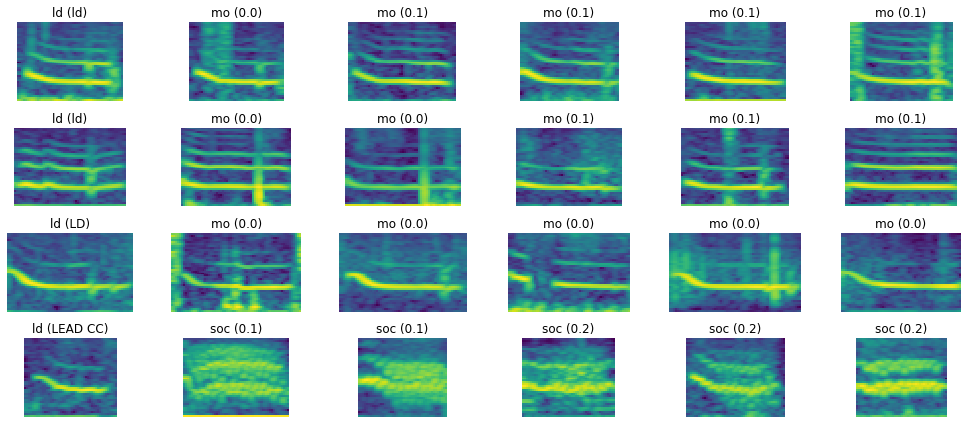

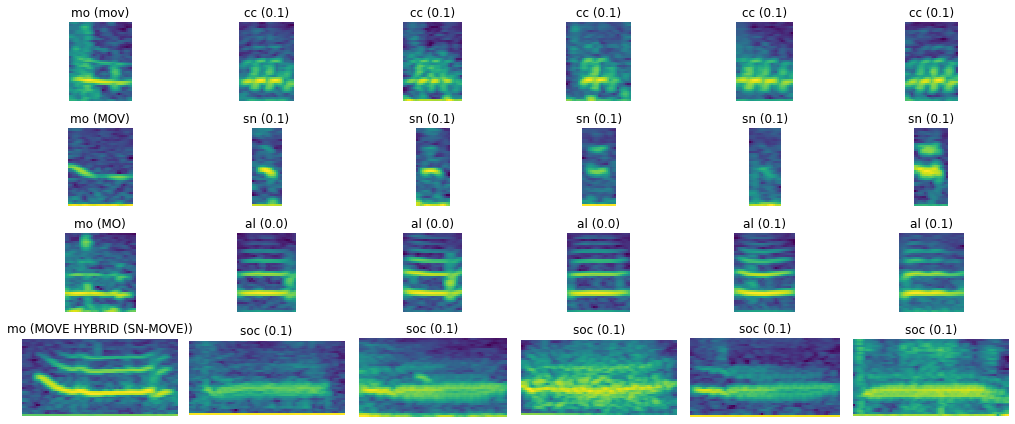

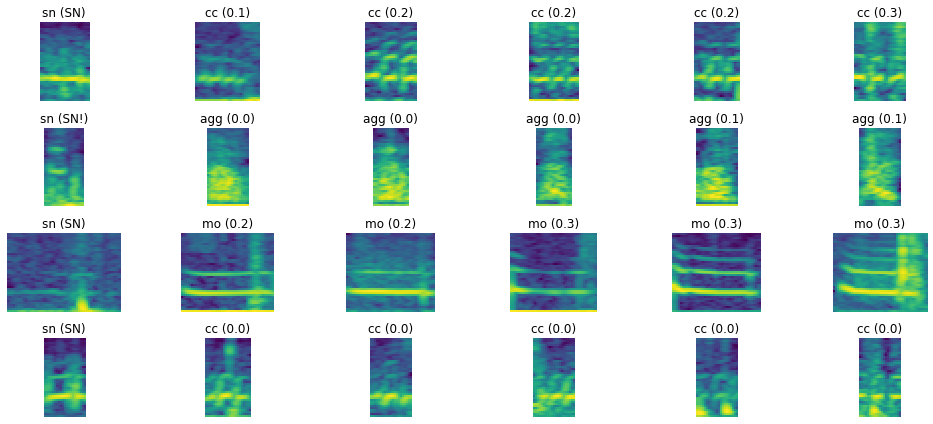

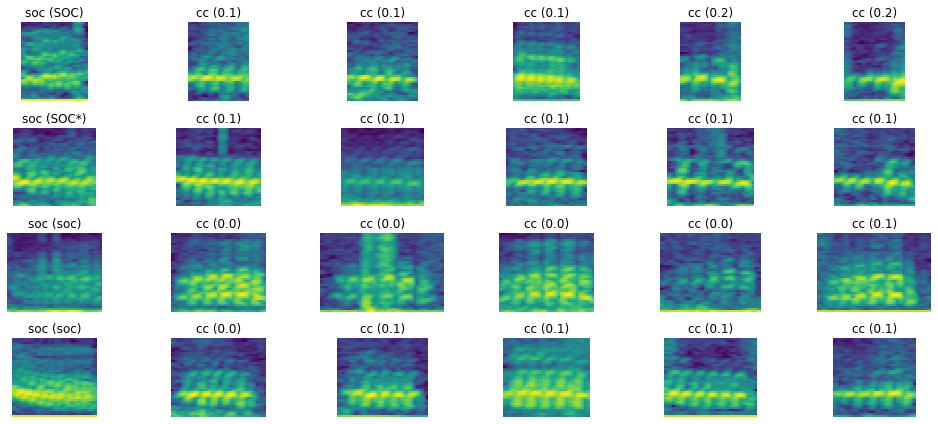

In [22]:
data=embedding
for calltype in calltypes:
    fig = plt.figure(figsize=(14,6))
    fig_name = 'NN_misclass_Viz_'+calltype
    p=1

    subset_df = wrong_subset.loc[wrong_subset['call_lable']==calltype,:]

      # randomly choose 4
    examples = subset_df.sample(n=4, random_state=1234)
    examples.reset_index(inplace=True)
  
    for i in range(examples.shape[0]):
        ori_rownum = examples.loc[i,'row_num']
        spec = spec_df.loc[ori_rownum,'spectrograms']
        plt.subplot(4, 6, p)
        plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
        plt.axis('off')
        original_name = spec_df.loc[ori_rownum,'Name']
        plt.title(calltype+" ("+original_name+")")
        p=p+1

        for neighbor in range(1,6):
            neighbor_label = examples.loc[i,'neighbor_'+str(neighbor)]
            nb_rownum = examples.loc[i,'neighbor_'+str(neighbor)+'_rownum']
            neighbor_spec = spec_df.loc[nb_rownum,'spectrograms']
            dist = scipy.spatial.distance.euclidean(data[ori_rownum,:], data[nb_rownum,:])
            plt.subplot(4, 6, p)
            plt.imshow(neighbor_spec, interpolation='nearest', origin='lower', aspect='equal') 
            plt.axis('off')
            plt.title(examples.loc[i,'neighbor_'+str(neighbor)]+" ("+str(round(dist,1))+")")
            p=p+1
        
    plt.tight_layout() 
    plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")

### Random select calls for manual assignment

From the subset of clearly misclassified calls, select a reasonable amount that Vlad and Baptiste can go through manually and check.

In [85]:
random_subset = wrong_subset.sample(n=100, random_state=1)
random_subset

row_num call_lable neighbor_1 neighbor_2 neighbor_3 neighbor_4  \
118      807         ld        soc        soc        soc        soc   
401     4128         mo         al         al         al         al   
235     1810        soc         cc         cc         cc         cc   
161     1173         sn         al         al         al         al   
468     4730         mo        soc        soc        soc        soc   
..       ...        ...        ...        ...        ...        ...   
260     1990         al         mo         mo         mo         mo   
140      958        soc         cc         cc         cc         cc   
300     2341        soc         cc         cc         cc         cc   
248     1879         mo         cc         cc         cc         cc   
285     2226         al        soc        soc        soc        soc   

    neighbor_5  neighbor_1_rownum  neighbor_2_rownum  neighbor_3_rownum  \
118        soc               1379                163                771   
401         al                355               2487                989   
235         cc               5947               5312               6381   
161         al               2878               2799               2890   
468        soc               2523               1309               4477   
..         ...                ...                ...                ...   
260         mo               4596               4665               4754   
140         cc               6168               5127               5608   
300         cc               5217               5519               5448   
248         cc               5331               6312               4990   
285        soc               2222               2223               4004   

     neighbor_4_rownum  neighbor_5_rownum clear_case  
118                795                699        yes  
401               2577               4371        yes  
235               5169               5666        yes  
161               4527               3782        yes  
468               2524               4025        yes  
..                 ...                ...        ...  
260               4837               4625        yes  
140               6086               6308        yes  
300               5005               5404        yes  
248               5413               6341        yes  
285               2568               2217        yes  

[100 rows x 13 columns]

In [86]:
random_subset['callID'] = [spec_df.loc[x,'callID'] for x in random_subset.row_num]
random_subset['spectrograms'] = [spec_df.loc[x,'spectrograms'] for x in random_subset.row_num]
random_subset['raw_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset.row_num]
random_subset['samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset.row_num]
random_subset['Name'] = [spec_df.loc[x,'Name'] for x in random_subset.row_num]
random_subset['nb_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset.neighbor_1_rownum]
random_subset['nb_samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset.neighbor_1_rownum]

In [87]:
for nb_num in range(1,6):
    random_subset['nb_'+str(nb_num)+'_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]
    random_subset['nb_'+str(nb_num)+'_samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]
    random_subset['nb_'+str(nb_num)+'_spectrograms'] = [spec_df.loc[x,'spectrograms'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]

In [88]:
random_subset.reset_index(inplace=True)

#### Save calls

In [89]:
outname = os.path.join(os.path.sep, DATA, 'random_sub_missclassi')
print(outname)
random_subset.to_pickle(outname+'.pkl')

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/random_sub_missclassi


In [90]:
#random_subset.samplerate_hz.value_counts()

### Save random subset wavs

In [91]:
random_subset = pd.read_pickle(os.path.join(os.path.sep, DATA, 'random_sub_missclassi')+'.pkl')

In [95]:
random_subset

index  row_num call_lable neighbor_1 neighbor_2 neighbor_3 neighbor_4  \
0     118      807         ld        soc        soc        soc        soc   
1     401     4128         mo         al         al         al         al   
2     235     1810        soc         cc         cc         cc         cc   
3     161     1173         sn         al         al         al         al   
4     468     4730         mo        soc        soc        soc        soc   
..    ...      ...        ...        ...        ...        ...        ...   
95    260     1990         al         mo         mo         mo         mo   
96    140      958        soc         cc         cc         cc         cc   
97    300     2341        soc         cc         cc         cc         cc   
98    248     1879         mo         cc         cc         cc         cc   
99    285     2226         al        soc        soc        soc        soc   

   neighbor_5  neighbor_1_rownum  neighbor_2_rownum  ...  \
0         soc               1379                163  ...   
1          al                355               2487  ...   
2          cc               5947               5312  ...   
3          al               2878               2799  ...   
4         soc               2523               1309  ...   
..        ...                ...                ...  ...   
95         mo               4596               4665  ...   
96         cc               6168               5127  ...   
97         cc               5217               5519  ...   
98         cc               5331               6312  ...   
99        soc               2222               2223  ...   

                                    nb_2_spectrograms  \
0   [[-4.901206, -6.0010366, -9.109212, -12.539943...   
1   [[-25.54695, -25.13933, -24.25471, -23.501272,...   
2   [[-26.290243, -25.084631, -24.247702, -25.5405...   
3   [[-27.783468, -26.476675, -25.881119, -25.5556...   
4   [[-9.126039, -8.945954, -8.795756, -8.969731, ...   
..                                                ...   
95  [[-40.05514, -37.677475, -35.31554, -34.712425...   
96  [[-19.183758, -18.41818, -18.101376, -19.96773...   
97  [[-36.797237, -31.10299, -27.791668, -27.47390...   
98  [[-25.436024, -20.405518, -14.647969, -11.1169...   
99  [[-5.3349633, -5.40929, -5.476499, -5.338552, ...   

                                           nb_3_audio  nb_3_samplerate_hz  \
0   [0.01171875, 0.021484375, 0.01953125, 0.019531...                8000   
1   [0.00390625, 0.00390625, 0.005859375, 0.005859...                8000   
2   [0.0, 0.001953125, 0.0078125, 0.0078125, 0.007...                8000   
3   [0.00390625, 0.001953125, 0.00390625, 0.003906...                8000   
4   [0.00390625, 0.005859375, 0.001953125, 0.00195...                8000   
..                                                ...                 ...   
95  [0.0029883385, 0.0030322075, 0.0032827854, 0.0...               48000   
96  [0.0, -0.021484375, -0.01171875, -0.005859375,...                8000   
97  [0.0021636486, 0.0021525621, 0.0021430254, 0.0...               48000   
98  [0.064453125, 0.0, -0.0234375, -0.00390625, 0....                8000   
99  [0.05859375, 0.060546875, 0.025390625, 0.10937...                8000   

                                    nb_3_spectrograms  \
0   [[-0.76804733, -0.9459286, -0.9663677, -0.6889...   
1   [[-23.381548, -22.871706, -22.364317, -22.9857...   
2   [[-20.121859, -20.208864, -20.337297, -20.1201...   
3   [[-25.42329, -26.164001, -27.551735, -28.11142...   
4   [[-29.695261, -30.772951, -32.807816, -31.6047...   
..                                                ...   
95  [[-24.856443, -25.415388, -27.02536, -29.34288...   
96  [[-20.588114, -18.2535, -11.9079275, -8.05273,...   
97  [[-28.891819, -26.869888, -24.73796, -24.3511,...   
98  [[-9.221613, -9.157368, -9.785242, -11.766037,...   
99  [[-3.8132408, -3.4416664, -3.0952137, -3.34717...   

                                           nb_4_audio nb_4_samp

### Wavs

In [93]:
os.path.join(os.path.sep, DATA, 'misclassi_calls')

'/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/misclassi_calls'

In [94]:
MISCLASSI_OUT = os.path.join(os.path.sep, DATA, 'misclassi_calls')

if (not os.path.isdir(MISCLASSI_OUT)):
    os.mkdir(MISCLASSI_OUT)

In [96]:
# Need to resample all at same samplerate!!!!
import soundfile as sf
from scipy.io import wavfile
import scipy.signal as sps


def write_wav(uid, data, sr):
    filename = str(uid)+'.wav'
    #if sr == SR:
    #    sf.write(filename, data, sr, subtype='PCM_16')
    #else: # resample
    #    print("Resampled for "+filename)
    #    number_of_samples = round(len(data) * float(SR) / sr)
    #    data = sps.resample(data, number_of_samples)
    sf.write(filename, data, sr, subtype='PCM_24')

os.chdir(MISCLASSI_OUT)

x=random_subset.apply(lambda row: write_wav(row['callID'], row['raw_audio'], row['samplerate_hz']), axis=1)

os.chdir(wd)

### Spec imgs

In [94]:
MISCLASSI_IMG_OUT = os.path.join(os.path.sep, DATA, 'misclassi_imgs')

if (not os.path.isdir(MISCLASSI_IMG_OUT)):
    os.mkdir(MISCLASSI_IMG_OUT)

In [100]:
n_ticks=3
FFT_WIN = 0.03
FFT_HOP = FFT_WIN/8
HOP_LEN = int(0.03*SR)
FMAX = 4000

for i in range(random_subset.shape[0]):
#for i in range(3):
    plt.figure(figsize=(12, 2))
    outname = str(random_subset.loc[i,'index'])+'.jpg'
    ori_rownum = random_subset.loc[i,'row_num']
    spec = spec_df.loc[ori_rownum,'spectrograms']
    plt.subplot(1, 6, 1)
    librosa.display.specshow(spec,sr=SR, hop_length=HOP_LEN , fmax=FMAX, y_axis='mel', cmap='inferno')

    # Generate axis labels
    #n_frames = spec.shape[1]
    duration = FFT_HOP*spec.shape[1]
    step_size = round(duration/n_ticks,2)
    myticks = np.arange(0,duration, step_size)
    plt.xticks([round(x/FFT_HOP,0) for x in myticks], [str(round(x,2)) for x in myticks])

    plt.title(spec_df.loc[ori_rownum,'call_lable'])
    p=2


    for neighbor in range(1,6):
        neighbor_label = random_subset.loc[i,'neighbor_'+str(neighbor)]
        nb_rownum = random_subset.loc[i,'neighbor_'+str(neighbor)+'_rownum']
        neighbor_spec = spec_df.loc[nb_rownum,'spectrograms']
        plt.subplot(1, 6, p)
        librosa.display.specshow(neighbor_spec,sr=SR, hop_length=HOP_LEN , fmax=FMAX, cmap='inferno')
        plt.xticks([round(x/FFT_HOP,0) for x in myticks], [str(round(x,2)) for x in myticks])
        plt.title(random_subset.loc[i,'neighbor_'+str(neighbor)])
        p=p+1

    plt.savefig(os.path.join(os.path.sep, MISCLASSI_IMG_OUT, outname))
    plt.close()


#### Info file

In [97]:
outname = os.path.join(os.path.sep, DATA, 'info.csv')
random_subset[['callID', 'call_lable', 'neighbor_1']].to_csv(outname, index=False)

In [98]:
x=pd.read_csv(outname)
x

callID call_lable neighbor_1
0   HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_A...         ld        soc
1   HM_VHMM017_RSTB_R23_20190708-20190720_file_10_...         mo         al
2   HM_VHMF001_HTB_R20_20190707-20190719_file_8_(2...        soc         cc
3   HM_RT_R10_20170903-20170908_file_4_(2017_09_05...         sn         al
4           HM_VLF206_SOUNDFOC_20170806_3___14:34.970         mo        soc
..                                                ...        ...        ...
95     HM_VHMF010_SOUNDFOC_20190714-028___1:56:23.014         al         mo
96  HM_LT_R09_20170903-20170908_file_4_(2017_09_05...        soc         cc
97  HM_VHMF019_MBTB_R25_20190707-20190719_file_6_(...        soc         cc
98  HM_VHMF001_HTB_R20_20190707-20190719_file_8_(2...         mo         cc
99  HM_VHMF015_RTTB_R05_20190707-20190719_file_8_(...         al        soc

[100 rows x 3 columns]

In [100]:
x.to_csv(outname, index=False, sep=";")
print(outname)

'/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/info.csv'